In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [59]:
stock_name = "DJI"
stock = pd.read_csv("sample_data/DJI.csv" )
print(stock.head())
print(stock.tail())
stock = stock[:]['Open']
stock.head()


         Date         Open         High  ...        Close    Adj Close    Volume
0  1985-01-29  1277.719971  1295.489990  ...  1292.619995  1292.619995  13560000
1  1985-01-30  1297.369995  1305.099976  ...  1287.880005  1287.880005  16820000
2  1985-01-31  1283.239990  1293.400024  ...  1286.770020  1286.770020  14070000
3  1985-02-01  1276.939941  1286.109985  ...  1277.719971  1277.719971  10980000
4  1985-02-04  1272.079956  1294.939941  ...  1290.079956  1290.079956  11630000

[5 rows x 7 columns]
            Date          Open  ...     Adj Close     Volume
8631  2019-04-29  26559.869141  ...  26554.390625  279450000
8632  2019-04-30  26594.560547  ...  26592.910156  340320000
8633  2019-05-01  26639.060547  ...  26430.140625  303850000
8634  2019-05-02  26407.150391  ...  26307.789063  287610000
8635  2019-05-03  26379.140625  ...  26504.949219  248900000

[5 rows x 7 columns]


0    1277.719971
1    1297.369995
2    1283.239990
3    1276.939941
4    1272.079956
Name: Open, dtype: float64

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [60]:
stock_scale = (stock - np.min(stock))*1.0/( np.max(stock) - np.min(stock))
stock_scale.head()

0    0.001329
1    0.002097
2    0.001545
3    0.001299
4    0.001109
Name: Open, dtype: float64

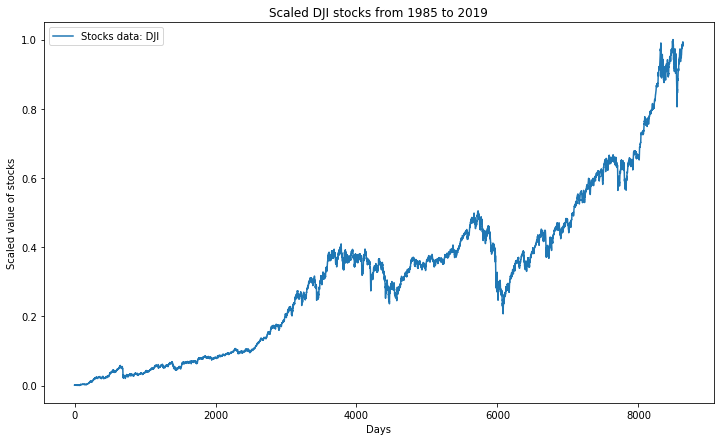

In [61]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled ' + stock_name + ' stocks from 1985 to 2019')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(stock_scale, label='Stocks data: '+stock_name)
plt.legend()
plt.show()

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [0]:
def window_data(stock_data, window_size):
    '''   
    Input: stock_data - stock price 
           window_size - time lag to predict the current price 
    
    Outputs: X - reshaped price data 
             y - label: the current price data 
    '''
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(stock_data) - 1:
        X.append(stock_data[i:i+window_size])
        y.append(stock_data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [0]:
time_lag = 7
X, y = window_data(stock_scale, time_lag)
NT  = len(y) 
NT_train = int( np.ceil(NT*0.95) )

In [64]:
X_train  = np.array(X[:NT_train])
y_train = np.array(y[:NT_train])

X_test = np.array(X[NT_train:])
y_test = np.array(y[NT_train:] )   #Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 128 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.005 
epochs = 50

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (8198, 7)
y_train size: (8198,)
X_test size: (431, 7)
y_test size: (431,)


# TesnorFlow Model

In [0]:
# place holder 
inputs = tf.placeholder(tf.float32, [batch_size, window_size])
targets = tf.placeholder(tf.float32, [batch_size])


In [0]:
# setup LSTM 

# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

In [0]:
## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [0]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [0]:
# formally store object of output at each time for each of batch input 
# no calculation really conducted 

outputs = []
for i in range(batch_size): 
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
    


In [0]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))  
    # reshape (-1, XX), -1 means unknown dimension
    
loss = tf.reduce_mean(losses)




In [0]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

# Training

In [72]:
session = tf.Session()

session.run(tf.global_variables_initializer())

for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))


Epoch 0/50  Current loss: 0.00035628810292109847
Epoch 10/50  Current loss: 0.00022909131075721234
Epoch 20/50  Current loss: 0.008503121323883533
Epoch 30/50  Current loss: 0.0035681528970599174
Epoch 40/50  Current loss: 0.005758319050073624


In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

# Testing

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [0]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [0]:
test_results = []
for i in range(NT):
    if i >= NT_train+window_size:
        test_results.append(tests_new[i- NT_train- window_size])
    else:
        test_results.append(None)

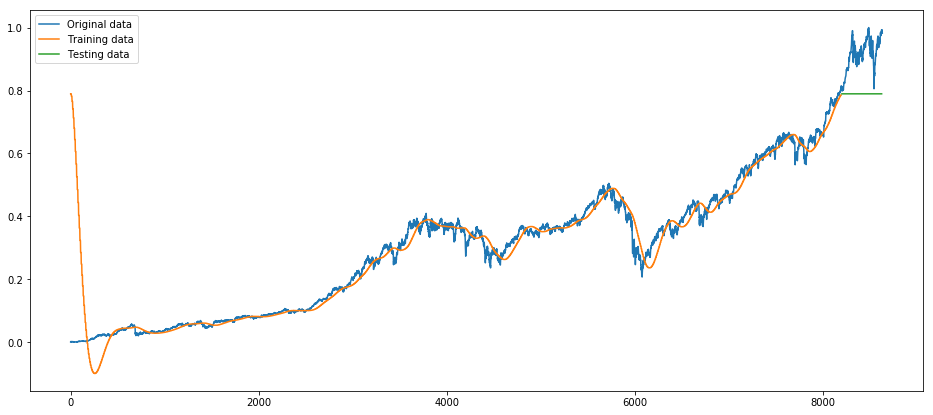

In [77]:
plt.figure(figsize=(16, 7))
plt.plot(stock_scale, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [0]:
session.close()